# Titanic survival project

<div align="center">
<img src="images/Titanic.jpg" width="500">
</div>

RMS Titanic was a British passenger liner, operated by the White Star Line, which sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, UK, to New York City. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew which made the sinking possibly one of the deadliest for a single ship up to that time. It remains to this day the deadliest peacetime sinking of a superliner or cruise ship.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others. This project aims to develop a machine learning classifiers to predict which passengers survived the Titanic shipwreck given features like age, gender, socio-economic class, etc.

## About the data

The data was downloaded from Kaggle and only the trainning set is in use for this project. The trainning set containg the target variable and can be used to evaluate our model. The test set, without the target, is used for predictions when participating in the Kaggle competition

<div align="center">
    <img src='images/data_table.png' width=500>
</div>

**Variable Notes**

- `pclass`: A proxy for socio-economic status (SES)<br> 
 1st: Upper<br> 
 2nd: Middle<br>
 3rd: Lower<br>

- `age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- `sibsp`: The dataset defines family relations in this way:<br>
Sibling: brother, sister, stepbrother, stepsister<br>
Spouse: husband, wife (mistresses and fiancés were ignored)<br>

- `parch`: The dataset defines family relations in this way:<br>
Parent: mother, father<br>
Child: daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.<br>

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
df = pd.read_csv('data/train.csv')
df.drop('PassengerId',axis=1,inplace=True)

## Exploratory Data Analysis

In [152]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [153]:
print(f'There are {df.shape[0]} rows in the data frame')
print(f'There are {df.shape[1]} columns in the data frame')

There are 891 rows in the data frame
There are 11 columns in the data frame


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


### Checking for missing values

In [155]:
df.isnull().values.any()

True

In [156]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

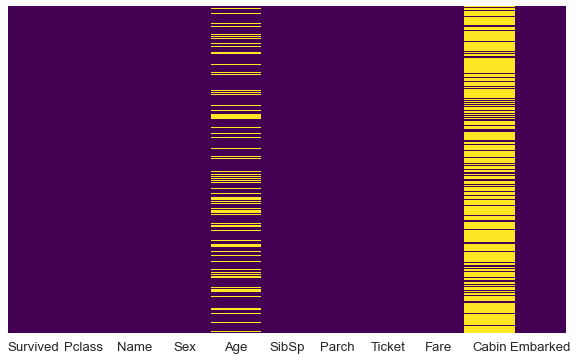

In [157]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

Three features in the train data set with missing values were found: `Cabin` (77% missing), `Age` (20% missing) and `Embarked` (only 2 observations missing). They will be investigated further in the feature engineering section.

In [158]:
def missing_value(df):
    """Function to return n and % of missing values  """
    number = df.isnull().sum().sort_values(ascending=False)
    number = number[number > 0]
    percentage = df.isnull().sum() *100 / df.shape[0]
    percentage = percentage[percentage > 0].sort_values(ascending=False)
    return  pd.concat([number,percentage],keys=["Total","Percentage"],axis=1)

In [159]:
missing_value(df)

,Total,Percentage
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


### Target feature: Survival

We will start with a check of the `Survived` column, a.k.a the target feature we will be trying to predict with the ML algorithms. A good start is with looking at the balance between the two classes in this feature.

In [160]:
surv=df['Survived'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'Survived','Survived':'percent'})

In [161]:
surv.iloc[0,0] = 'No'
surv.iloc[1,0] = 'Yes'

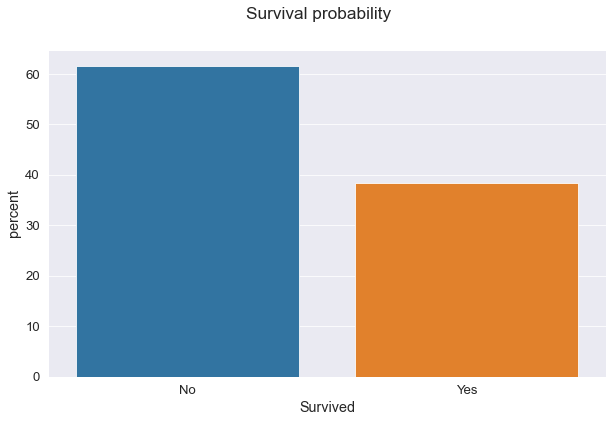

In [162]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.set_context('paper',font_scale=1.5)

plt.suptitle('Survival probability')
sns.barplot(x='Survived',y='percent',data=surv);

Over 60% of individuals didn't survived in the train data set. 

Next we will look at the survival rate in the different features.

### Sex vs Survival rate

In [163]:
sex=df.groupby('Sex')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [164]:
sex

,Sex,Survived,percent
0,female,1,74.203822
1,female,0,25.796178
2,male,0,81.109185
3,male,1,18.890815


In [165]:
sex_dist = df['Sex'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'Sex','Sex':'percent'})

In [166]:
sex_dist

,Sex,percent
0,male,64.758698
1,female,35.241302


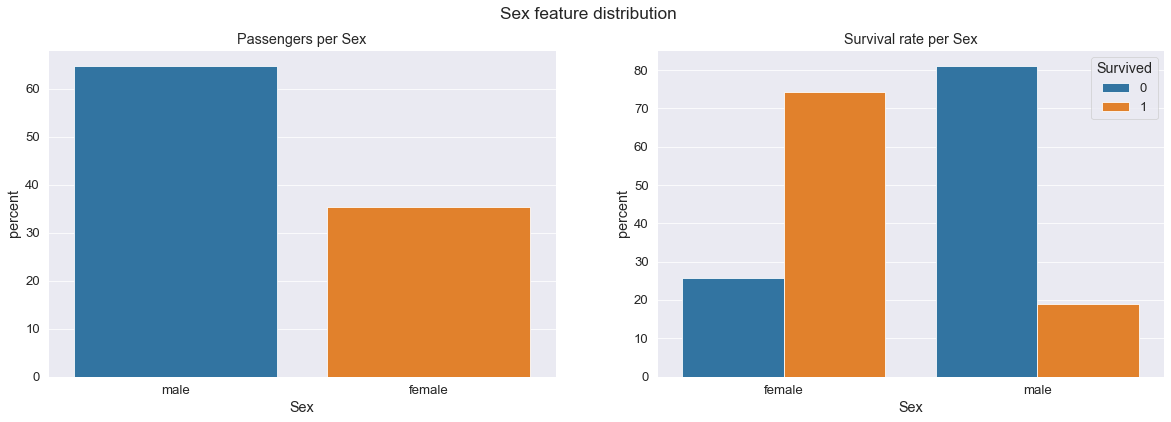

In [167]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)
plt.suptitle('Sex feature distribution')
axs[0].set_title('Passengers per Sex')
axs[1].set_title('Survival rate per Sex')

sns.barplot(ax=axs[0],x='Sex',y='percent',data=sex_dist)
sns.barplot(ax=axs[1],x='Sex',y='percent',hue='Survived',data=sex);

From the figure above becomes clear that male passengers in the train dataset represented over 60% of the individuals. Most of them did not survive the disaster (80%). It is also intersting to see in the figure below the age distribution of males and females. It is possible to note that passengers over 60 years were mainly males and that the distribution between classes of ages 0 to 60 are similar for both sex.

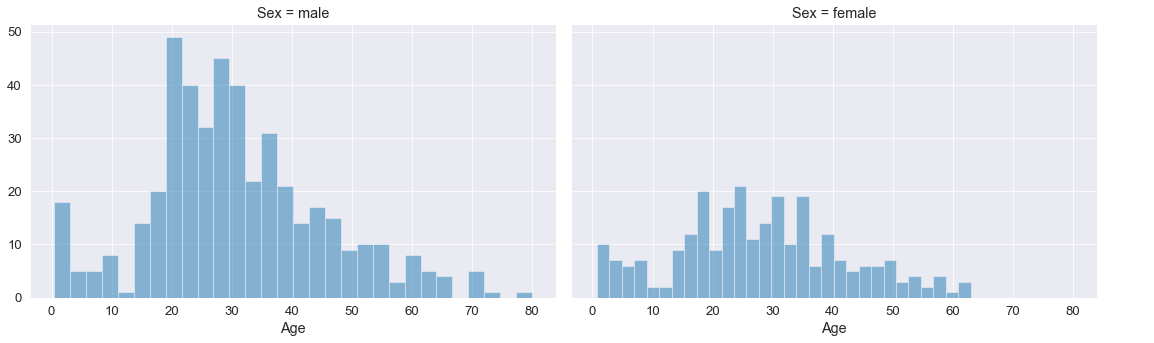

In [168]:
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=2)

grid = sns.FacetGrid(data=df,
                     col='Sex',
                     margin_titles=True,height=5,aspect=1.6,legend_out=True,despine=False)

grid.map(plt.hist,'Age',alpha=0.5,bins=30)
grid.add_legend();

Now, if we split the age distribution one more level and look at the them across the `Survived` label, it seems that most male passengers over 60 did not survive the disaster.

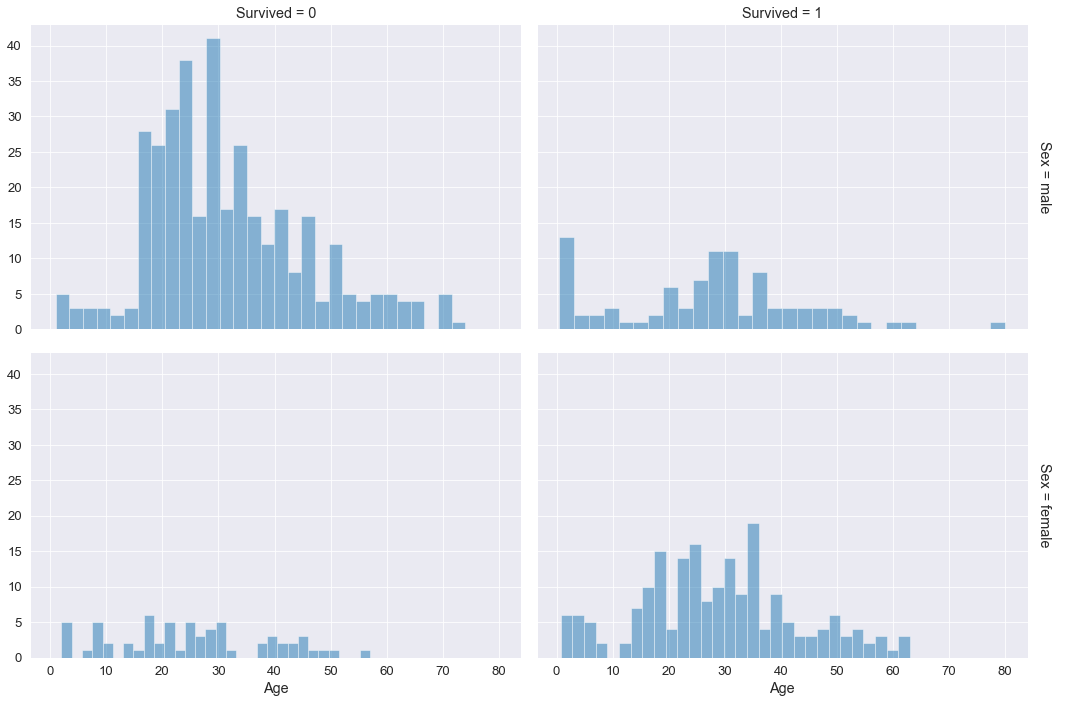

In [169]:
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

grid = sns.FacetGrid(data=df,
                     col='Survived',
                     row='Sex',
                     margin_titles=True,height=5,aspect=1.5,legend_out=True,despine=False)

grid.map(plt.hist,'Age',alpha=0.5,bins=30)
grid.add_legend();

### Pclass vs Survival rate

In [170]:
pclass=df.groupby('Pclass')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [171]:
pclass

,Pclass,Survived,percent
0,1,1,62.962963
1,1,0,37.037037
2,2,0,52.717391
3,2,1,47.282609
4,3,0,75.763747
5,3,1,24.236253


In [172]:
pclass_dist = df['Pclass'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'Pclass','Pclass':'percent'})

In [173]:
pclass_dist

,Pclass,percent
0,3,55.106622
1,1,24.242424
2,2,20.650954


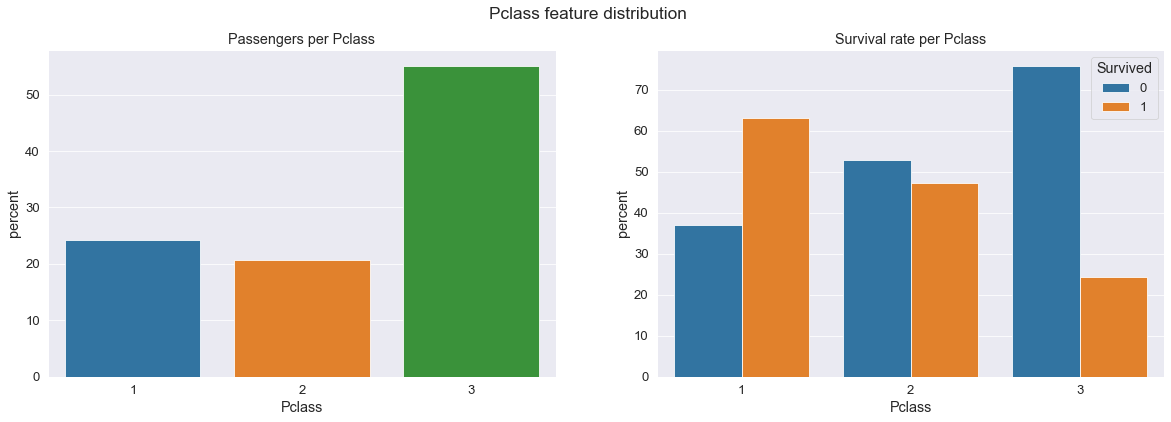

In [174]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

plt.suptitle('Pclass feature distribution')
axs[0].set_title('Passengers per Pclass')
axs[1].set_title('Survival rate per Pclass')

sns.barplot(ax=axs[0],x='Pclass',y='percent',data=pclass_dist);
sns.barplot(ax=axs[1], x='Pclass',y='percent',data=pclass,hue='Survived');

Most of passenger were traveling in third class (~55%) and more than 75% of them did not survived. First class passengers were the ones with highes chance of survival (over 50%) while passengers on second class had similar chances of survival.

We could now add `Age` to the mix to investigate age structure in the different `Pclasses` to build a bit more out intuition on how the different features interact to each other.

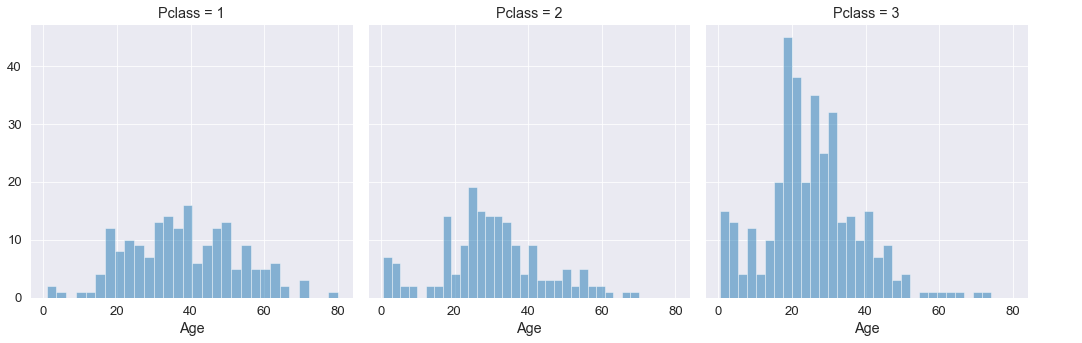

In [175]:
sns.set_style('darkgrid')

grid = sns.FacetGrid(data=df,
                     #col='Survived',
                     col='Pclass',
                     margin_titles=True,height=5,aspect=1,legend_out=True,despine=False)

grid.map(plt.hist,'Age',alpha=0.5,bins=30)
grid.add_legend();

Most of youngsters were traveling on third class while the older passengers seem to be concentrated in first class. At least we can't really see much passengers less than 20 years in first class as much as second and third.

Building up to an analysis of the `Age` sctructure per `Pclass` against `Survived` to comfirm the trend. Again, third classe with higher percetage of youngsters that did not survive can be inferred from the figure below.

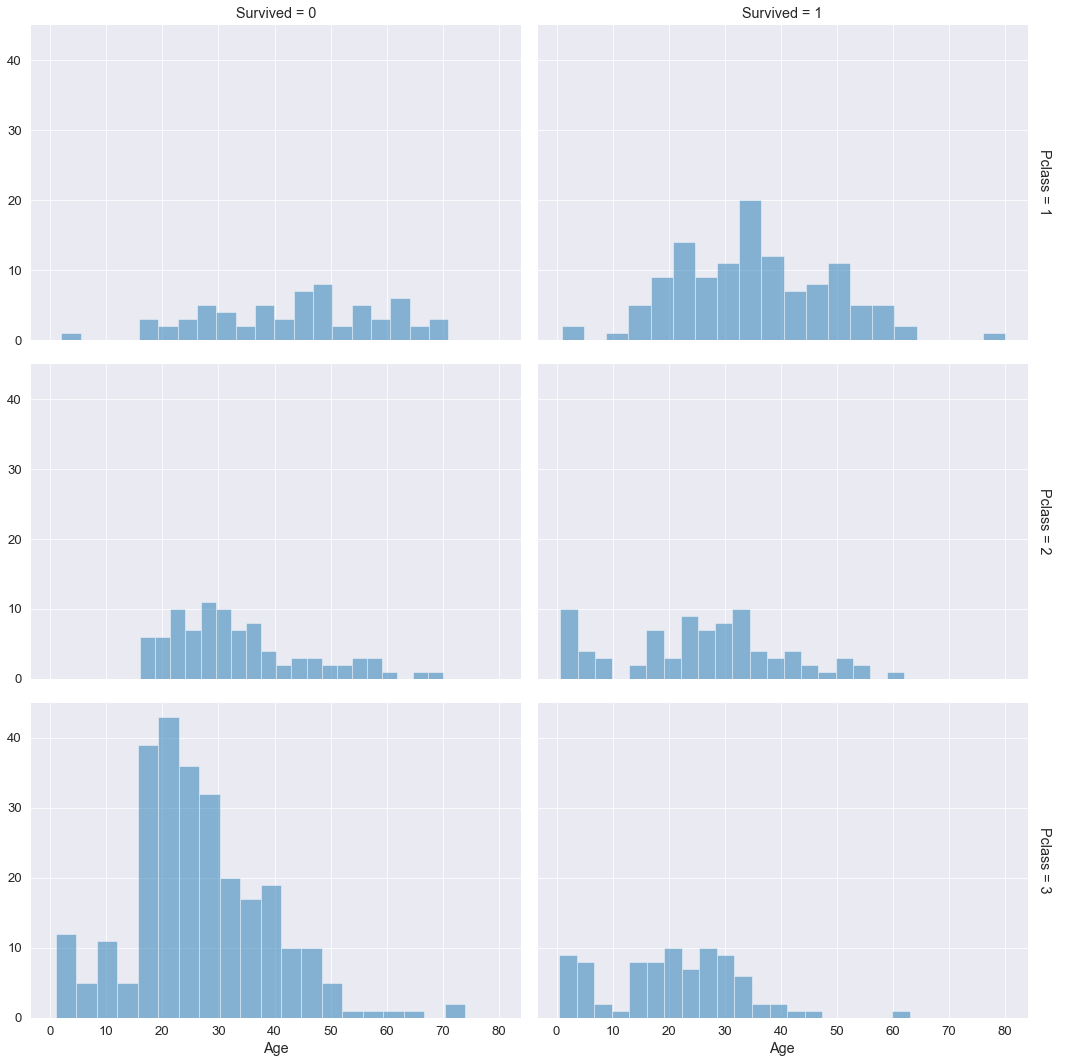

In [176]:
sns.set_style('darkgrid')

grid = sns.FacetGrid(data=df,
                     col='Survived',
                     row='Pclass',
                     margin_titles=True,height=5,aspect=1.5,legend_out=True,despine=False)

grid.map(plt.hist,'Age',alpha=0.5,bins=20)
grid.add_legend();

Perhaps we should also look at the proportion of males and females per `Pclass`.

In [177]:
sex_pclass=df.groupby('Pclass')['Sex'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [178]:
sex_pclass

,Pclass,Sex,percent
0,1,male,56.481481
1,1,female,43.518519
2,2,male,58.695652
3,2,female,41.304348
4,3,male,70.672098
5,3,female,29.327902


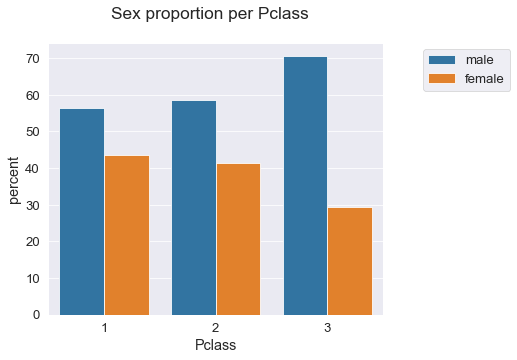

In [179]:
fig, axs = plt.subplots(figsize=(6,5))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

plt.suptitle('Sex proportion per Pclass')

sns.barplot(x='Pclass',y='percent',hue='Sex',data=sex_pclass,ci=False)
plt.legend(bbox_to_anchor=(1.1,1));


As expected most of males were traveling on third class.

### Parch vs Survival rate

Continuing with our 'demographics' exploration we will have a look at `Parch` feature that contains the number of parents and children also on board the Titanic for each passenger.

In [180]:
parch=df.groupby('Parch')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [181]:
parch

,Parch,Survived,percent
0,0,0,65.634218
1,0,1,34.365782
2,1,1,55.084746
3,1,0,44.915254
4,2,0,50.000000
5,2,1,50.000000
6,3,1,60.000000
7,3,0,40.000000
8,4,0,100.000000
9,5,0,80.000000


In [182]:
parch_dist = df['Parch'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'Parch','Parch':'percent'})

In [183]:
parch_dist

,Parch,percent
0,0,76.094276
1,1,13.243547
2,2,8.978676
3,5,0.561167
4,3,0.561167
5,4,0.448934
6,6,0.112233


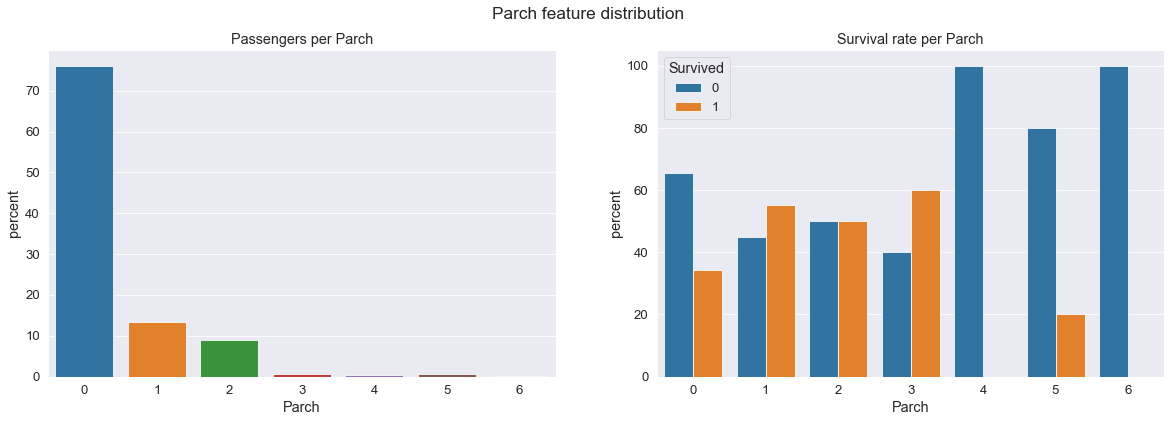

In [184]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

plt.suptitle('Parch feature distribution')
axs[0].set_title('Passengers per Parch')
axs[1].set_title('Survival rate per Parch')

sns.barplot(ax=axs[0],x='Parch',y='percent',data=parch_dist);
sns.barplot(ax=axs[1], x='Parch',y='percent',data=parch,hue='Survived');

More than 75% of the passengers had no parents nor children on board the Titanic and over 65% of them did not surivive. However it is important to note that passengers with `Parch` over 4 had even lower survival rate.

### SibSp vs Survival rate

In [185]:
sibsp=df.groupby('SibSp')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [186]:
sibsp

,SibSp,Survived,percent
0,0,0,65.460526
1,0,1,34.539474
2,1,1,53.588517
3,1,0,46.411483
4,2,0,53.571429
5,2,1,46.428571
6,3,0,75.000000
7,3,1,25.000000
8,4,0,83.333333
9,4,1,16.666667


In [187]:
sibsp_dist = df['SibSp'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'SibSp','SibSp':'percent'})

In [188]:
sibsp_dist

,SibSp,percent
0,0,68.237935
1,1,23.456790
2,2,3.142536
3,4,2.020202
4,3,1.795735
5,8,0.785634
6,5,0.561167


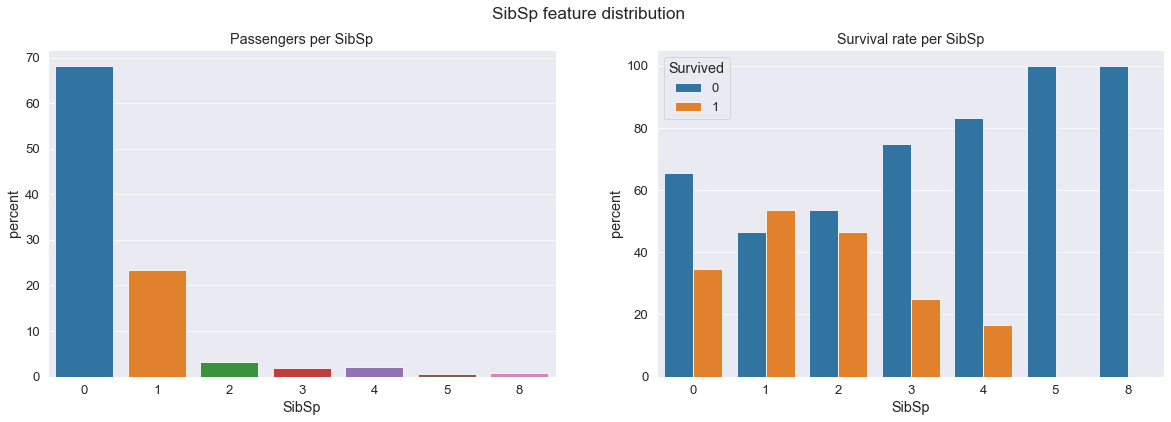

In [189]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

plt.suptitle('SibSp feature distribution')
axs[0].set_title('Passengers per SibSp')
axs[1].set_title('Survival rate per SibSp')

sns.barplot(ax=axs[0],x='SibSp',y='percent',data=sibsp_dist);
sns.barplot(ax=axs[1], x='SibSp',y='percent',data=sibsp,hue='Survived');

Following the trend observed in the `Parch` feature, it seems most of the passengers also didn't have either spouse or siblins on board the Titanic and the survival rate of those with 3 or more `Parch` was also extremely low. 

### Combining Parch and SibSp

As a test we will use the features `Parch`and `SibSp` and unite them in a new feature called `Family` where we will classify passengers as travelling with family members or not.

In [190]:
def sib_family(row):
    if row['SibSp'] > 0:
        return 1
    else:
        return 0
df['SibSp'] = df.apply(lambda row: sib_family(row),axis=1)

In [191]:
def par_family(row):
    if row['Parch'] > 0:
        return 1
    else:
        return 0
df['Parch'] = df.apply(lambda row: par_family(row),axis=1)

In [192]:
df['Family'] = df['SibSp'] + df['Parch']

In [193]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [194]:
def family(row):
    if row['Family'] > 0:
        return 1
    else:
        return 0
df['Family'] = df.apply(lambda row: family(row),axis=1)

In [195]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [196]:
df['Family'].value_counts()

0    537
1    354
Name: Family, dtype: int64

In [197]:
fam_dist = df['Family'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'Family','Family':'percent'})

In [198]:
fam_dist

,Family,percent
0,0,60.26936
1,1,39.73064


In [199]:
fam = df.groupby('Family')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [200]:
fam

,Family,Survived,percent
0,0,0,69.646182
1,0,1,30.353818
2,1,1,50.564972
3,1,0,49.435028


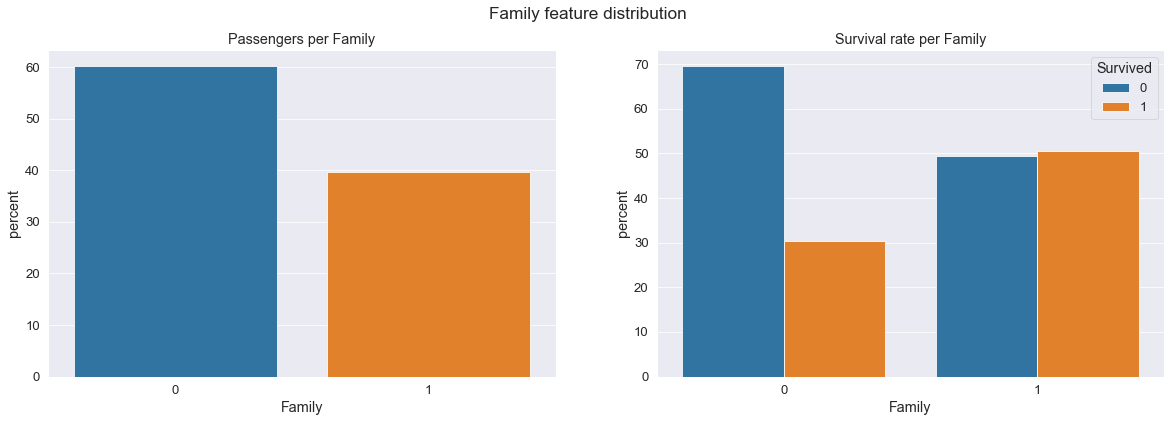

In [201]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

plt.suptitle('Family feature distribution')
axs[0].set_title('Passengers per Family')
axs[1].set_title('Survival rate per Family')

sns.barplot(ax=axs[0],x='Family',y='percent',data=fam_dist);
sns.barplot(ax=axs[1], x='Family',y='percent',data=fam,hue='Survived');

Excellent. Now we know that "loners" had 60% chance of not surviving while passengers traveling with family had equal chance of survivng.

### Summarizing demographics analysis

Some good intuition is already built from the data exploration on the demographics of Titanic passengers done so far. 
Before we continue let's summarize what've lerned so far:

- Most of passengers did not survived
- Most of passengers were men 
- Most of passengers were young under 40 years old (men and women)
- Most of passengers were traveling in 3rd class (men and women)
- Most passemger were traveling alone
- Chance of survival seem to be related to number of family members traveling together

Now we will look at the `Embarkaed` feature, representing the ports were the passengeres embarqued Titanic: Cherbourg (C), Queenstown (Q), Southampton (S)

### Embarked vs Survival rate

In [202]:
embkd = df.groupby('Embarked')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [203]:
embkd

,Embarked,Survived,percent
0,C,1,55.357143
1,C,0,44.642857
2,Q,0,61.038961
3,Q,1,38.961039
4,S,0,66.304348
5,S,1,33.695652


In [204]:
embkd_dist = df['Embarked'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'Embarked','Embarked':'percent'})

In [205]:
embkd_dist

,Embarked,percent
0,S,72.440945
1,C,18.897638
2,Q,8.661417


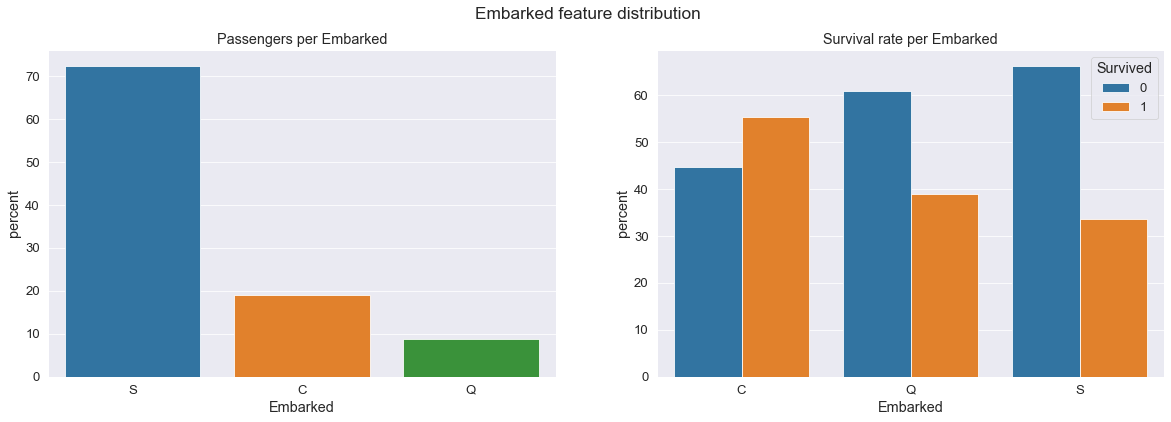

In [206]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

plt.suptitle('Embarked feature distribution')
axs[0].set_title('Passengers per Embarked')
axs[1].set_title('Survival rate per Embarked')

sns.barplot(ax=axs[0],x='Embarked',y='percent',data=embkd_dist);
sns.barplot(ax=axs[1], x='Embarked',y='percent',data=embkd,hue='Survived');

Most passengers  got on board in Southampton and passengers that embarked in Cherbourg had higher survival rate.

### Fare vs Pclass

Last but not least, the `Fare` feature will be investigated. We want to look into the relationship between fare and `Pclass` as I would expect some sort of pricing difference.

In [207]:
fare = df.groupby('Pclass')['Fare'].describe()

In [208]:
fare.transpose()

Pclass,1,2,3
count,216.000000,184.000000,491.000000
mean,84.154687,20.662183,13.675550
std,78.380373,13.417399,11.778142
min,0.000000,0.000000,0.000000
25%,30.923950,13.000000,7.750000
50%,60.287500,14.250000,8.050000
75%,93.500000,26.000000,15.500000
max,512.329200,73.500000,69.550000


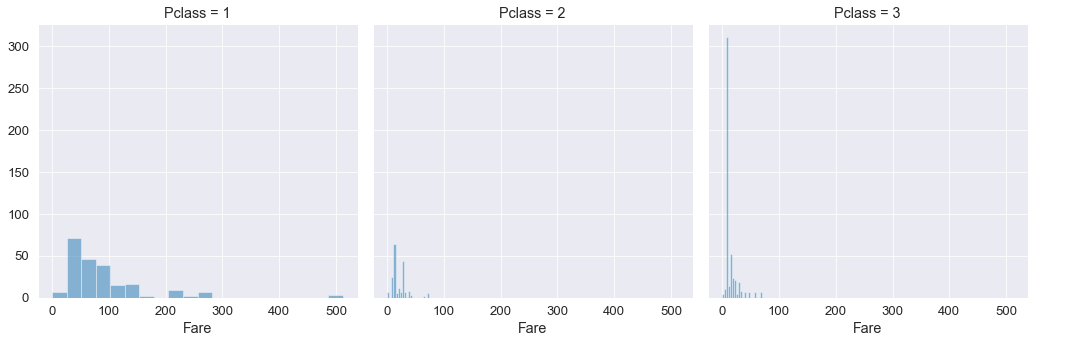

In [209]:
sns.set_style('darkgrid')

grid = sns.FacetGrid(data=df,
                     #row='Embarked',
                     col='Pclass',
                     margin_titles=True,height=5,aspect=1,legend_out=True,despine=False)

grid.map(plt.hist,'Fare',alpha=.5,bins=20)
grid.add_legend();

It is clear that there a significant price difference for the different classes onboard and it seems that the features `Fare`and `Pclass` are redundant.

### Cabin vs Survival rate

Looking now at the `Cabin` feature where 77% of the data is missing. 

In [210]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [211]:
# Fill na with letter 'U' from Unknown to be used for analysis against Survived
df['Cabin'].fillna('U',inplace=True)

In [212]:
cabin_letter = df.copy()

In [213]:
cabin_letter['cabin_letter'] = cabin_letter['Cabin'].str[0]

In [214]:
c_letter = cabin_letter.groupby('cabin_letter')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [215]:
c_letter

,cabin_letter,Survived,percent
0,A,0,53.333333
1,A,1,46.666667
2,B,1,74.468085
3,B,0,25.531915
4,C,1,59.322034
5,C,0,40.677966
6,D,1,75.757576
7,D,0,24.242424
8,E,1,75.000000
9,E,0,25.000000


In [216]:
c_letter_dist = cabin_letter['cabin_letter'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'cabin_letter','cabin_letter':'percent'})

In [217]:
c_letter_dist

,cabin_letter,percent
0,U,77.104377
1,C,6.621773
2,B,5.274972
3,D,3.703704
4,E,3.591470
5,A,1.683502
6,F,1.459035
7,G,0.448934
8,T,0.112233


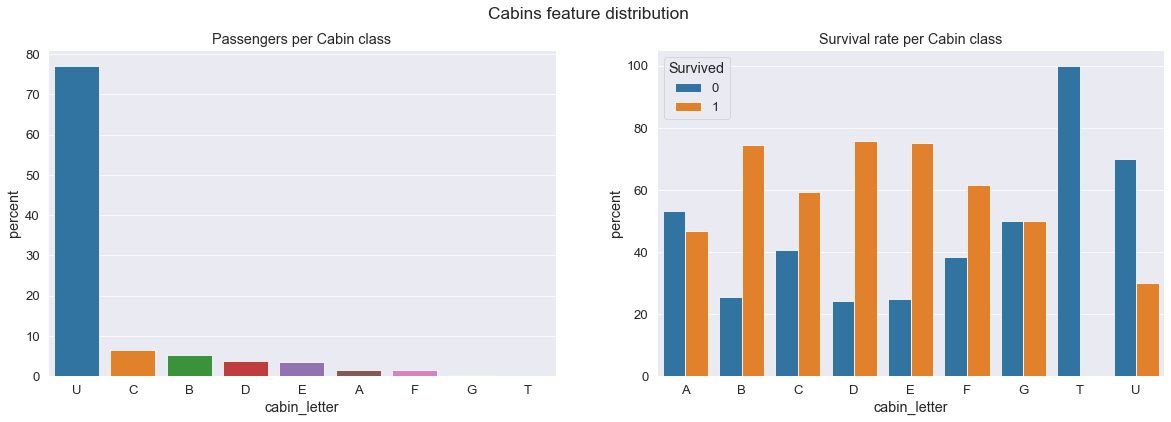

In [218]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

plt.suptitle('Cabins feature distribution')
axs[0].set_title('Passengers per Cabin class')
axs[1].set_title('Survival rate per Cabin class')

sns.barplot(ax=axs[0],x='cabin_letter',y='percent',data=c_letter_dist);
sns.barplot(ax=axs[1], x='cabin_letter',y='percent',data=c_letter,hue='Survived');

It seems `Cabin` is a good candidate to be also engineered into 2 single classes (known and unkown) since it seems that passagers with known cabins had more change of surviving.

### Name vs Survival rate

Intuitively your name should not increaseor decrease your chance of survival but the title in the name might be of some use. We will extract the title and check it against the survival rate.

In [219]:
# check unique titles
df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Name, dtype: int64

In [220]:
c = df['Name']

In [221]:
c = c.tolist()

In [222]:
d = []

def ttle(name):
    for i in c:
        if 'Mr.' in i:
            d.append('Mr')
        elif 'Dr.' in i:
            d.append('Mr')
        elif 'Rev.' in i:
            d.append('Mr')
        elif 'Col.' in i:
            d.append('Mr')
        elif 'Capt.' in i:
            d.append('Mr')
        elif 'Major.' in i:
            d.append('Mr')
        elif 'Don.' in i:
            d.append('Mr')
        elif 'Sir.' in i:
            d.append('Mr')
        
        elif 'Master.' in i:
            d.append('Master')
        
        elif 'Miss.' in i:
            d.append('Miss')
        elif 'Mlle.' in i:
            d.append('Miss')
        elif 'Mme.' in i:
            d.append('Miss')
        elif 'Ms.' in i:
            d.append('Miss')
            
        elif 'Mrs.' in i:
            d.append('Mrs')
        elif 'Countess.' in i:
            d.append('Mrs')
        elif 'Lady.' in i:
            d.append('Mrs')
        elif 'Dona.' in i:
            d.append('Mrs')
            
ttle(c)

In [223]:
d2 = pd.Series(d)

In [224]:
d2.value_counts()

Mr        537
Miss      186
Mrs       127
Master     40
dtype: int64

In [225]:
df['Title'] = d2

In [226]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,0,Mr


In [227]:
title_dist = df['Title'].value_counts(normalize=True).mul(100).reset_index().rename(columns={'index': 'Title','Title':'percent'})

In [228]:
title_dist

,Title,percent
0,Mr,60.337079
1,Miss,20.898876
2,Mrs,14.269663
3,Master,4.494382


In [229]:
title = df.groupby('Title')['Survived'].value_counts(normalize=True).mul(100).rename('percent').reset_index()


In [230]:
title

,Title,Survived,percent
0,Master,1,57.500000
1,Master,0,42.500000
2,Miss,1,69.354839
3,Miss,0,30.645161
4,Mr,0,82.122905
5,Mr,1,17.877095
6,Mrs,1,74.015748
7,Mrs,0,25.984252


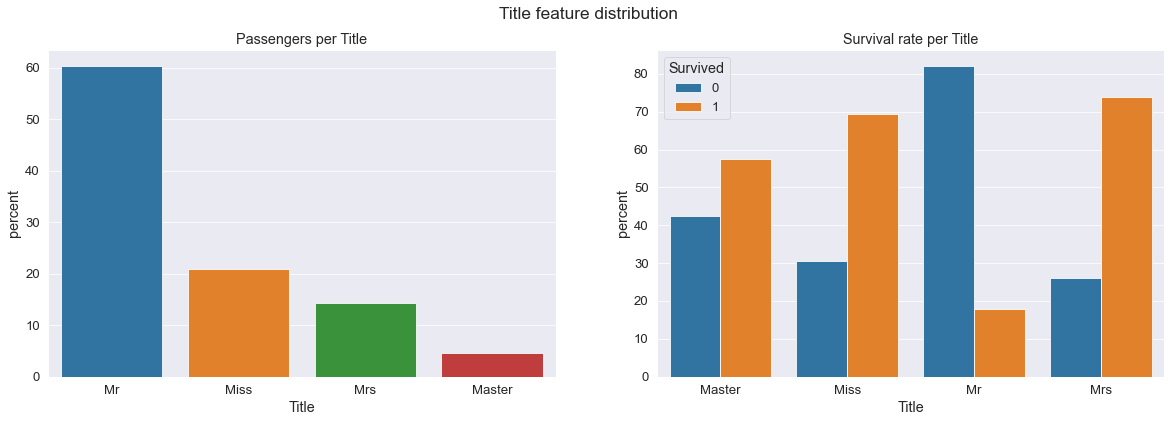

In [231]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
sns.set_style('darkgrid')
#sns.set_context('paper',font_scale=1)

plt.suptitle('Title feature distribution')
axs[0].set_title('Passengers per Title')
axs[1].set_title('Survival rate per Title')

sns.barplot(ax=axs[0],x='Title',y='percent',data=title_dist);
sns.barplot(ax=axs[1], x='Title',y='percent',data=title,hue='Survived');

The survival rate across different titles is surprinsingly balanced. We will later drop the name and keep only the title as a engineered feature.

In [232]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,0,Mr


We will now have a look at the corrrelation between categorical features to try to improve our understanding on how they can 'explain' each other and help us make decisions on which one we should keep, engineer or drop.

In [233]:
#pip install  dython

In [234]:
from dython.nominal import associations

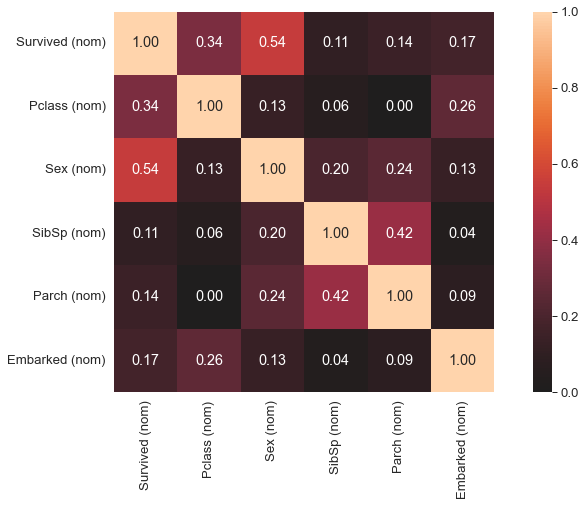

In [235]:
# sns.set_context('paper',font_scale=1.2)

cat_cols = ['Survived', 'Pclass', 'Sex', 'SibSp',
            'Parch', 'Cabin', 'Embarked']

fig1 = associations(df.drop(['Name','Ticket','Age','Fare','Family','Cabin','Title'],axis=1),
                    figsize=(14,7),
                    nominal_columns=cat_cols,
                    #title='Fig. 1. Associations between features.',
                    mark_columns=True);

_____

## Feature engineering and preparation

___

### Cabin feature

We decided to drop the cabin feature due to the amount of missing value

In [236]:
df.drop('Cabin',axis=1,inplace=True)

### Age feature

From the EDA above we built an intuiton that age seem to be well connected to the different `Pclass` on board Titanic maybe as a result of the difference in the ticket price across the classes. One could assume than younger people would have less money than older, better established man, and therefore would travel on third class instead. We decided to give another check to confirm this theory. See below:

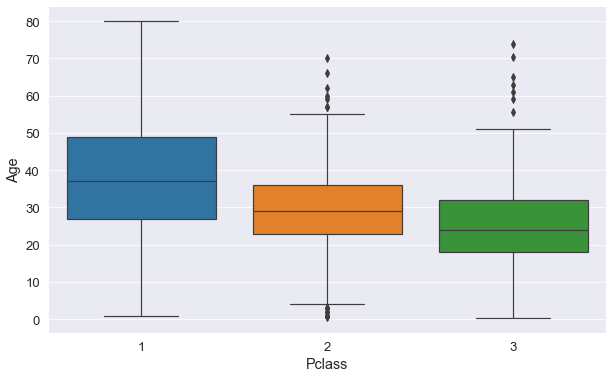

In [237]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Pclass',y='Age',data=df);

Above we can see the boxplot distribution of `Age` per `Pclass` and it does seem that the average age distribution is different for each class.

Let's have a look at a kde plot to double check the change:

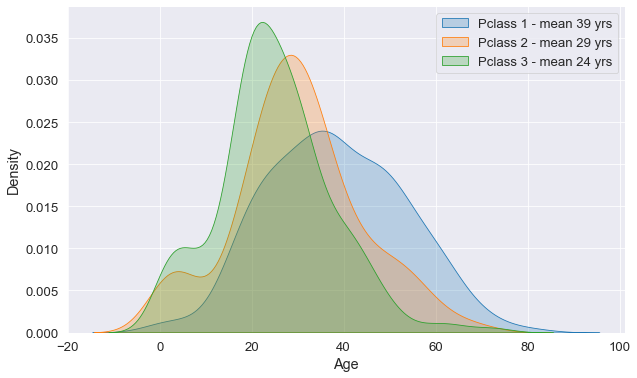

In [238]:
fig, axs = plt.subplots(figsize=(10,6))

sns.kdeplot(df['Age'][df['Pclass'] == 1],legend=True,label='Pclass 1 - mean 39 yrs',shade=True)
sns.kdeplot(df['Age'][df['Pclass'] == 2],legend=True,label='Pclass 2 - mean 29 yrs',shade=True)
sns.kdeplot(df['Age'][df['Pclass'] == 3],legend=True,label='Pclass 3 - mean 24 yrs',shade=True)
plt.legend();

In [239]:
df.groupby('Pclass')['Age'].describe().transpose()

Pclass,1,2,3
count,186.000000,173.000000,355.000000
mean,38.233441,29.877630,25.140620
std,14.802856,14.001077,12.495398
min,0.920000,0.670000,0.420000
25%,27.000000,23.000000,18.000000
50%,37.000000,29.000000,24.000000
75%,49.000000,36.000000,32.000000
max,80.000000,70.000000,74.000000


In [240]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 39

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [241]:
df['Age'] = df[['Age','Pclass']].apply(impute_age,axis=1)

### Embarked feature

Only 2 missing data here. Checking the passengers individually.

In [242]:
df[df['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,Title
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,0,Miss
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,0,Mrs


Filtering the full data set and counting of all passangers on 1st class that paid 80 or more for the ticked:

In [243]:
sim_embarked = df[(df.Pclass == 1) & 
                  (df['Fare'] >= 80)]
sim_embarked['Embarked'].value_counts()

C    38
S    34
Q     2
Name: Embarked, dtype: int64

Decided to impute these 2 individuals as 'C' 

In [244]:
df['Embarked'].fillna('C',inplace=True)

### Tidying up

In [247]:
df = df.drop(['Fare','Name','SibSp','Parch','Ticket'],axis=1)

In [248]:
df.head()

,Survived,Pclass,Sex,Age,Embarked,Family,Title
0,0,3,male,22.0,S,1,Mr
1,1,1,female,38.0,C,1,Mrs
2,1,3,female,26.0,S,0,Miss
3,1,1,female,35.0,S,1,Mrs
4,0,3,male,35.0,S,0,Mr


___

## Machine Learning

___

We will change Pclass numbers for letters to avoid passing the idea of order to the machine learning algorithm. 3rd class is not 3 times the value of the 1st class

In [125]:
df['Pclass'] = df['Pclass'].map({1:'A',2:'B',3:'C'})

In [126]:
df = pd.get_dummies(df,drop_first=True)

In [127]:
df.head()

,Survived,Age,Family,Pclass_B,Pclass_C,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs
0,0,22.0,1,0,1,1,0,1,0,1,0
1,1,38.0,1,0,0,0,0,0,0,0,1
2,1,26.0,0,0,1,0,0,1,1,0,0
3,1,35.0,1,0,0,0,0,1,0,0,1
4,0,35.0,0,0,1,1,0,1,0,1,0


In [130]:
from sklearn.model_selection import train_test_split 

In [132]:
X = df.drop('Survived',axis=1)
y = df['Survived']    

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.1, random_state=101)

### Base model

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

In [136]:
print('Parameters currently in use:\n')
gb_model.get_params()

Parameters currently in use:



{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter tunning

In [137]:
from sklearn.model_selection import GridSearchCV

In [138]:
param_grid = {'n_estimators':[15,20,25],
              'learning_rate':[0.9,0.95,1,1.02,1.05],
              'max_depth':[1,2,3,4]}

In [139]:
grid = GridSearchCV(gb_model,param_grid)

In [140]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.9, 0.95, 1, 1.02, 1.05],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [15, 20, 25]})

In [141]:
grid.best_params_

{'learning_rate': 1.05, 'max_depth': 2, 'n_estimators': 15}

In [142]:
cv_results = pd.DataFrame(grid.cv_results_)

In [143]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012733,0.001562,0.002166,0.000174,0.9,1,15,"{'learning_rate': 0.9, 'max_depth': 1, 'n_esti...",0.770186,0.86875,0.79375,0.80625,0.76250,0.800287,0.037681,33
1,0.011059,0.000150,0.001889,0.000176,0.9,1,20,"{'learning_rate': 0.9, 'max_depth': 1, 'n_esti...",0.763975,0.88125,0.80000,0.80625,0.78125,0.806545,0.040189,22
2,0.015915,0.003305,0.002120,0.000574,0.9,1,25,"{'learning_rate': 0.9, 'max_depth': 1, 'n_esti...",0.782609,0.88125,0.80000,0.80000,0.78750,0.810272,0.036146,11
3,0.011051,0.000260,0.001851,0.000145,0.9,2,15,"{'learning_rate': 0.9, 'max_depth': 2, 'n_esti...",0.782609,0.85625,0.80000,0.78750,0.82500,0.810272,0.027277,11
4,0.013477,0.000051,0.001770,0.000037,0.9,2,20,"{'learning_rate': 0.9, 'max_depth': 2, 'n_esti...",0.757764,0.86250,0.80625,0.78125,0.83125,0.807803,0.036750,16


In [144]:
cv_results['mean_test_score'].mean()

0.799870082815735

### Model Evaluation

In [145]:
y_pred = grid.predict(X_test)

In [146]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score

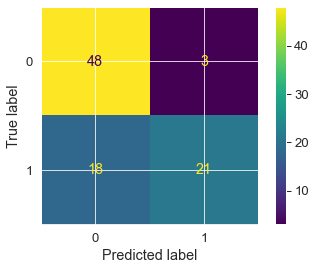

In [147]:
plot_confusion_matrix(grid,X_test,y_test);

In [148]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        51
           1       0.88      0.54      0.67        39

    accuracy                           0.77        90
   macro avg       0.80      0.74      0.74        90
weighted avg       0.79      0.77      0.75        90

